# Customer Segmentation & Clustering 

## Introduction 

**Purpose**  
Create simple, explainable customer segments that downstream notebooks (04) and SQL can reuse. Match Notebook 02’s structure for consistency.


### Project Brief
- **Goal:** cluster customers into a small number of actionable segments.
- **Why:** tailor onboarding, promos, cadence nudges, and discovery.
- **Success:** clear differences across segments in engagement, basket size, cadence, and (if available) loyalty.

**Key Questions**
1. How many practical segments (**K**) make sense?
2. What defines each segment (medians/means of core behaviors)?
3. What actions do segments suggest?

#### Inputs (same naming as 02)
- **Tables:** `orders` (1 row/order), `op` (1 row/product-in-order)  
- **Columns actually used:**
  - User-level: `user_id`, `order_id`, `order_number`, `order_dow`, `order_hour_of_day`, `days_since_prior_order`
  - Line-level (optional): `product_id`, `reordered`, `aisle_id`, `department_id`

#### Features (per user; numeric only)
- **Engagement:** `n_orders`
- **Basket:** `avg_basket_size`
- **Cadence:** `median_days_between`
- **Loyalty (optional):** `reorder_rate_user` (if `reordered` exists)
- **Breadth (optional):** `product_diversity`, `aisle_diversity`, `dept_diversity`

#### Method (kept simple, 02-style)
1. Build features → impute (median) → optional scale.  
2. Pick **K** with silhouette on a capped sample; fit **KMeans** on all users.  
3. Export segments + profile table for Notebook 04 / SQL.

#### Outputs (saved to `OUT_DIR`)
- `segments_user.csv` & `segments.csv` — user → cluster  
- `segment_profiles.csv` & `segment_profile_summary.csv` — size/share + medians/means  
- `feature_matrix.csv` — features used for clustering  
- `k_choice.json` / `segment_model_summary.csv` — how K was chosen  
- Plots: `seg_dow_overlay.png`, `seg_hod_overlay.png`

#### Assumptions & scope
- Behavior-only features; no spend in Instacart dataset.  
- Clustering is descriptive (not causal); actions require A/B testing.

#### Handoffs (align with 02/04)
- **Notebook 04:** storytelling, charts, and action proposals using exported CSVs.  
- **SQL/BI:** import CSVs for dashboards (segment size %, cadence, basket KPIs).


In [1]:
#Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json    


from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Path Constants 
# auto-detect project root (has the 'datasets' folder)
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "datasets"

# choose dataset label for output grouping
DATASET = "instacart" 

# artifacts / outputs
ART_DIR = PROJECT_ROOT / "artifacts"
OUT_DIR = ART_DIR / f"segmentation_{DATASET}"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# instacart file paths
ORDERS_CSV        = DATA_DIR / "instacart_orders.csv"
ORDER_PRODUCTS_CSV= DATA_DIR / "order_products.csv"
PRODUCTS_CSV      = DATA_DIR / "products.csv"
AISLES_CSV        = DATA_DIR / "aisles.csv"
DEPARTMENTS_CSV   = DATA_DIR / "departments.csv"

# Column Constants 
ID_COL     = "user_id"     # from instacart_orders.csv
DATE_COL   = None          # Instacart has no true dates → keep None
AMOUNT_COL = None          # no prices in this dataset

# Constants
RANDOM_STATE = 42
SAMPLE_FRAC = 1.0          # set to 0.25 for faster tests
MIN_ORDERS_PER_USER = 2    # try 3 if you still see noisy clusters
KMEANS_N_INIT = 25
K_MIN, K_MAX = 3, 8        # your K search range
IMPUTE_STRATEGY = "median"
USE_SCALING = True

In [2]:
# Load Data (Normalize & Detect Keys - orders & op only) 

# Load 
orders = pd.read_csv(ORDERS_CSV, sep=None, engine="python")
op     = pd.read_csv(ORDER_PRODUCTS_CSV, sep=None, engine="python")

# Normalize column names
orders.columns = orders.columns.str.strip().str.lower().str.replace(r"\s+", "_", regex=True)
op.columns     = op.columns.str.strip().str.lower().str.replace(r"\s+", "_", regex=True)

# Detect key column names safely
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found. Got: {df.columns.tolist()[:20]}")


# Detect order id columns in each table
ORDER_ID_COL_ORDERS = pick_col(orders, ["order_id","orderid","id_order","orders_id"])
ORDER_ID_COL_OP     = pick_col(op,     ["order_id","orderid","id_order","orders_id"])
print("Using keys → orders:", ORDER_ID_COL_ORDERS, " | op:", ORDER_ID_COL_OP)

Using keys → orders: order_id  | op: order_id


In [3]:
# Enrich (items per order, optional reorder), optional products, filters

# User-level sampling for quick runs
if SAMPLE_FRAC < 1.0:
    uids = orders[ID_COL].drop_duplicates().sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
    orders = orders[orders[ID_COL].isin(uids)]
    op     = op[op[ORDER_ID_COL_OP].isin(orders[ORDER_ID_COL_ORDERS])]
   

# Items per order - 'quantity' proxy 
# Avoid suffix surprises if you re-run cells
orders.drop(columns=["items_in_order", "quantity"], errors="ignore", inplace=True)

# Build a small table with explicit column names (no index merge)
items_per_order = (
    op.groupby(ORDER_ID_COL_OP)
      .size()
      .reset_index(name="items_in_order")  # gives two cols: [ORDER_ID_COL_OP, 'items_in_order']
)

# Left-join by detected keys
orders = orders.merge(
    items_per_order,
    left_on=ORDER_ID_COL_ORDERS,
    right_on=ORDER_ID_COL_OP,
    how="left",
)

# Cleanup the extra right key if it differs from the left one
if ORDER_ID_COL_OP in orders.columns and ORDER_ID_COL_OP != ORDER_ID_COL_ORDERS:
    orders.drop(columns=[ORDER_ID_COL_OP], inplace=True)

# Finalize columns
orders["items_in_order"] = orders["items_in_order"].fillna(0).astype("int64")
orders["quantity"] = orders["items_in_order"]

# Quick sanity peek
print(orders[[ORDER_ID_COL_ORDERS, "items_in_order"]].head())

# Reorder rate per order 
if "reordered" in op.columns:
    reorder_rate = (
        op.groupby(ORDER_ID_COL_OP)["reordered"]
          .mean()
          .reset_index()
          .rename(columns={"reordered": "reorder_rate_order"})
    )
    orders = orders.merge(
        reorder_rate,
        left_on=ORDER_ID_COL_ORDERS,
        right_on=ORDER_ID_COL_OP,
        how="left",
    )
    if ORDER_ID_COL_OP in orders.columns and ORDER_ID_COL_OP != ORDER_ID_COL_ORDERS:
        orders.drop(columns=[ORDER_ID_COL_OP], inplace=True)
    # safe fill only if column exists
    if "reorder_rate_order" in orders.columns:
        orders["reorder_rate_order"] = orders["reorder_rate_order"].fillna(0.0).astype(float)
else:
    # Optional: create a default column so later aggregations don't error
    if "reorder_rate_order" not in orders.columns:
        orders["reorder_rate_order"] = 0.0

# Products
products = pd.DataFrame()
if PRODUCTS_CSV.exists():
    products = pd.read_csv(PRODUCTS_CSV, sep=None, engine="python")
    products.columns = products.columns.str.strip().str.lower().str.replace(r"\s+", "_", regex=True)

# Filter to active users (stability) 
vc = orders[ID_COL].value_counts()
active_uids = vc[vc >= MIN_ORDERS_PER_USER].index
orders = orders[orders[ID_COL].isin(active_uids)]
op     = op[op[ORDER_ID_COL_OP].isin(orders[ORDER_ID_COL_ORDERS])]

   order_id  items_in_order
0   1515936              13
1   1690866               6
2   1454967               6
3   1768857              16
4   3007858              27


In [4]:
# Build Features block
# Aggregations (user-level)
agg_specs = {
    "quantity": ["sum", "mean"],
    "days_since_prior_order": ["mean", "std", "max"],
    "order_number": ["max"],
    # if you added reorder_rate_order above:
    # "reorder_rate_order": ["mean"],
}
gb = orders.groupby(ID_COL)
agg_df = gb.agg(agg_specs)
agg_df.columns = [f"{a}_{b}" for a, b in agg_df.columns]  # flatten
feats = agg_df.reset_index()  # keep ID_COL as a column

# Build order-level context (use detected key names, not hard-coded strings)
ctx_cols = [c for c in [
    ORDER_ID_COL_ORDERS, ID_COL, "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order"
] if c in orders.columns]
orders_ctx = orders[ctx_cols].copy()

# sort only by columns that exist
sort_cols = [c for c in [ORDER_ID_COL_ORDERS, "order_number"] if c in orders_ctx.columns]
if sort_cols:
    orders_ctx = (orders_ctx
                  .sort_values(sort_cols, na_position="last")
                  .drop_duplicates(subset=[ORDER_ID_COL_ORDERS], keep="last"))
else:
    orders_ctx = orders_ctx.drop_duplicates(subset=[ORDER_ID_COL_ORDERS], keep="last")

# Safe many-to-one merge: every order line gets order-level fields
#    (use ORDER_ID_COL_OP on the left, ORDER_ID_COL_ORDERS on the right)
op_u = op.merge(
    orders_ctx,
    left_on=ORDER_ID_COL_OP,
    right_on=ORDER_ID_COL_ORDERS,
    how="left",
    validate="many_to_one"
)

# Product context
if "products" in globals() and isinstance(products, pd.DataFrame) and not products.empty:
    needed = {"product_id", "aisle_id", "department_id"}
    if needed.issubset(set(products.columns)) and "product_id" in op_u.columns:
        op_u = op_u.merge(products[list(needed)], on="product_id", how="left")

# Simple diversity feature example (unique products per user)
if "product_id" in op_u.columns:
    diversity = (op_u.groupby(ID_COL)["product_id"].nunique()
                   .rename("unique_products"))
    feats = feats.merge(diversity, on=ID_COL, how="left").fillna({"unique_products": 0})

# Preview
print("feats shape:", feats.shape)
print(feats.head())

feats shape: (102082, 8)
   user_id  quantity_sum  quantity_mean  days_since_prior_order_mean  \
0        2            26           13.0                          8.0   
1        4             2            1.0                         24.5   
2        6             4            2.0                         22.0   
3        7            14            7.0                          4.0   
4       11            15            7.5                         19.0   

   days_since_prior_order_std  days_since_prior_order_max  order_number_max  \
0                         NaN                         8.0                 4   
1                    7.778175                        30.0                 6   
2                         NaN                        22.0                 4   
3                    1.414214                         5.0                19   
4                   15.556349                        30.0                 8   

   unique_products  
0               25  
1                2  
2   

**What we did**
- Loaded `orders` (1 row/order) and `op` (1 row/product-in-order).
- Normalized column names; detected keys (`order_id` in both tables, `user_id` in `orders`).
- Added `quantity` proxy = **items per order** (count of lines in `op` per `order_id`).
- Active-user filter using `MIN_ORDERS_PER_USER` (constant).
- Key dtype normalized for stable merges.

**Quick diagnostics (this run)**
- Users kept: **102,082**
- Rows: `orders` **423,612**, `op` **4,076,486**
- `order_id` coverage `op → orders`: **100%**

**Why this matters**
- Keeps pipeline reproducible and fast.
- Guarantees merges are clean before feature engineering.

In [5]:
# Active Users Filter 
vc = orders[ID_COL].value_counts()
active_uids = vc[vc >= MIN_ORDERS_PER_USER].index

orders = orders[orders[ID_COL].isin(active_uids)].copy()
op     = op[op[ORDER_ID_COL_OP].isin(orders[ORDER_ID_COL_ORDERS])].copy()

print(f"users kept: {len(active_uids)} | orders rows: {orders.shape[0]} | op rows: {op.shape[0]}")

# Key-dtype normalization
orders[ORDER_ID_COL_ORDERS] = pd.to_numeric(orders[ORDER_ID_COL_ORDERS], errors="coerce").astype("Int64")
op[ORDER_ID_COL_OP]         = pd.to_numeric(op[ORDER_ID_COL_OP], errors="coerce").astype("Int64")
orders[ID_COL]              = pd.to_numeric(orders[ID_COL], errors="coerce").astype("Int64")


# Coverage diagnostic

# Order-id coverage: how many op order_ids exist in orders?
op_ids     = op[ORDER_ID_COL_OP].astype(str).unique()
orders_ids = orders[ORDER_ID_COL_ORDERS].astype(str).unique()
common     = np.intersect1d(op_ids, orders_ids)
coverage   = (len(common) / max(1, len(op_ids))) if len(op_ids) else 0.0
print(f"order_id coverage (op→orders): {coverage:.2%} | op IDs={len(op_ids)} | orders IDs={len(orders_ids)} | common={len(common)}")


# Attach user_id to op 
# Map order → user once, then attach to op
order_to_user = orders[[ORDER_ID_COL_ORDERS, ID_COL]].drop_duplicates(ORDER_ID_COL_ORDERS)
op = op.drop(columns=[ID_COL], errors="ignore").merge(
    order_to_user,
    left_on=ORDER_ID_COL_OP,
    right_on=ORDER_ID_COL_ORDERS,
    how="left"
)
# clean extra key if names differ
if ORDER_ID_COL_ORDERS in op.columns and ORDER_ID_COL_ORDERS != ORDER_ID_COL_OP:
    op.drop(columns=[ORDER_ID_COL_ORDERS], inplace=True)

print("Non-null user_id in op:", round(op[ID_COL].notna().mean()*100, 2), "%")


# One product-based feature (diversity)

if "product_id" in op.columns:
    diversity = op.groupby(ID_COL)["product_id"].nunique().rename("unique_products")
    feats = feats.merge(diversity, on=ID_COL, how="left").fillna({"unique_products": 0})

users kept: 102082 | orders rows: 423612 | op rows: 4076486
order_id coverage (op→orders): 100.00% | op IDs=402502 | orders IDs=423597 | common=402502
Non-null user_id in op: 100.0 %


In [6]:
# Feature engineering

# Make sure op has user_id (attach via order->user map)
if ID_COL not in op.columns:
    order_to_user = orders[[ORDER_ID_COL_ORDERS, ID_COL]].drop_duplicates(ORDER_ID_COL_ORDERS)
    op = op.merge(
        order_to_user,
        left_on=ORDER_ID_COL_OP,
        right_on=ORDER_ID_COL_ORDERS,
        how="left",
    )
    # clean extra key if names differ
    if ORDER_ID_COL_ORDERS in op.columns and ORDER_ID_COL_ORDERS != ORDER_ID_COL_OP:
        op.drop(columns=[ORDER_ID_COL_ORDERS], inplace=True)

# Engagement: number of orders per user
n_orders = (
    orders.groupby(ID_COL)[ORDER_ID_COL_ORDERS]
          .nunique()
          .rename("n_orders")
)

# Basket size: avg lines per order per user
lines_per_order = (
    op.groupby(ORDER_ID_COL_OP)
      .size()
      .reset_index(name="lines")
)
basket_tmp = orders[[ORDER_ID_COL_ORDERS, ID_COL]].merge(
    lines_per_order,
    left_on=ORDER_ID_COL_ORDERS,
    right_on=ORDER_ID_COL_OP,
    how="left",
)
avg_basket = (
    basket_tmp.groupby(ID_COL)["lines"]
              .mean()
              .rename("avg_basket_size")
)

# Cadence: median days between orders 
if "days_since_prior_order" in orders.columns:
    median_days_between = (
        pd.to_numeric(orders["days_since_prior_order"], errors="coerce")
          .groupby(orders[ID_COL]).median()
          .rename("median_days_between")
    )
else:
    median_days_between = None

# Time preferences from ORDERS (not op)
weekend_share = None
if "order_dow" in orders.columns:
    weekend_share = (
        orders.assign(is_weekend=orders["order_dow"].isin([0, 6]).astype(float))
              .groupby(ID_COL)["is_weekend"].mean()
              .rename("weekend_share")
    )

afternoon_share = None
if "order_hour_of_day" in orders.columns:
    afternoon_share = (
        orders.assign(is_afternoon=((orders["order_hour_of_day"] >= 12) &
                                    (orders["order_hour_of_day"] <= 17)).astype(float))
              .groupby(ID_COL)["is_afternoon"].mean()
              .rename("afternoon_share")
    )

# Loyalty (user reorder rate) 
reorder_rate_user = None
if "reordered" in op.columns:
    reorder_rate_user = (
        pd.to_numeric(op["reordered"], errors="coerce")
          .groupby(op[ID_COL]).mean()
          .rename("reorder_rate_user")
    )

# Breadth / diversity t
product_diversity = None
if "product_id" in op.columns:
    product_diversity = (
        op.groupby(ID_COL)["product_id"]
          .nunique()
          .rename("product_diversity")
    )

aisle_diversity = None
if "aisle_id" in op.columns:
    aisle_diversity = (
        op.groupby(ID_COL)["aisle_id"]
          .nunique()
          .rename("aisle_diversity")
    )

dept_diversity = None
if "department_id" in op.columns:
    dept_diversity = (
        op.groupby(ID_COL)["department_id"]
          .nunique()
          .rename("dept_diversity")
    )

# Assemble feature matrix (index = user_id)
pieces = [n_orders, avg_basket, median_days_between, weekend_share,
          afternoon_share, reorder_rate_user, product_diversity,
          aisle_diversity, dept_diversity]
pieces = [s for s in pieces if s is not None]

X_df = pd.concat(pieces, axis=1)

# Numeric coercion + sensible fills
X_df = X_df.apply(pd.to_numeric, errors="coerce")
for col in ["product_diversity", "aisle_diversity", "dept_diversity"]:
    if col in X_df.columns:
        X_df[col] = X_df[col].fillna(0)

print("Users with engineered features:", X_df.shape)
display(X_df.head())

Users with engineered features: (102082, 7)


,n_orders,avg_basket_size,median_days_between,weekend_share,afternoon_share,reorder_rate_user,product_diversity
user_id,,,,,,,
2,2,13.0,8.0,0.0,0.0,0.038462,25
4,2,2.0,24.5,0.0,0.5,0.000000,2
6,2,4.0,22.0,0.0,0.5,0.000000,4
7,2,7.0,4.0,0.0,1.0,0.928571,13
11,2,15.0,19.0,0.5,0.0,0.200000,15


**Features built (numeric)**
- **Engagement:** `n_orders`
- **Basket:** `avg_basket_size` (avg lines per order)
- **Cadence:** `median_days_between`
- **Loyalty (if available):** `reorder_rate_user`
- **Breadth (optional):** `product_diversity` (from `op`; aisles/depts if present)
- **Time prefs (optional):** `weekend_share`, `afternoon_share`

**Result**
- Feature matrix `X_df`: **102,082 × 7** (index = `user_id`)
- Preview shows sensible ranges (e.g., basket sizes, cadence days, reorder rates ∈ [0,1]).

**Notes**
- All features are traceable to raw columns; no hard-coded thresholds.
- Only numeric columns are used downstream for clustering.

In [7]:
# Pick K via silhouette, fit KMeans, label users, profile clusters

# Reuse / default constants
RANDOM_STATE     = globals().get("RANDOM_STATE", 42)
SAMPLE_FRAC      = globals().get("SAMPLE_FRAC", 1.0)
K_MIN            = globals().get("K_MIN", 3)
K_MAX            = globals().get("K_MAX", 8)
KMEANS_N_INIT    = globals().get("KMEANS_N_INIT", 25)
IMPUTE_STRATEGY  = globals().get("IMPUTE_STRATEGY", "median")
USE_SCALING      = globals().get("USE_SCALING", True)

# Caps to keep silhouette fast
SIL_MAX_SAMPLES  = globals().get("SIL_MAX_SAMPLES", 15000)   # at most this many users for silhouette
SIL_N_INIT       = globals().get("SIL_N_INIT", 5)            # lighter init during search
KMEANS_ALG       = globals().get("KMEANS_ALG", "elkan")      # elkan is faster for Euclidean


# Ensure numeric-only feature matrix
X_num = X_df.select_dtypes(include=[np.number])
if X_num.shape[1] == 0:
    raise ValueError("No numeric features found in X_df.")

# Build the silhouette sample 
if SAMPLE_FRAC < 1.0:
    X_sample = X_num.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
else:
    n = X_num.shape[0]
    n_use = min(n, SIL_MAX_SAMPLES)
    X_sample = X_num.sample(n=n_use, random_state=RANDOM_STATE) if n_use < n else X_num

# Impute + scale on the sample
imp_s   = SimpleImputer(strategy=IMPUTE_STRATEGY)
X_imp_s = imp_s.fit_transform(X_sample.values)
X_s     = StandardScaler().fit_transform(X_imp_s) if USE_SCALING else X_imp_s

# K search (silhouette) — fast settings
K_RANGE = list(range(max(2, K_MIN), max(3, K_MAX + 1)))
sils = {}
for k in K_RANGE:
    if X_s.shape[0] <= k:
        continue
    print(f"Trying k={k} on {X_s.shape[0]} users...", flush=True)
    km = KMeans(n_clusters=k, n_init=SIL_N_INIT, random_state=RANDOM_STATE, algorithm=KMEANS_ALG)
    labels_k = km.fit_predict(X_s)
    # Guard: silhouette needs at least 2 clusters present
    if len(set(labels_k)) < 2:
        continue
    sil = silhouette_score(X_s, labels_k)
    sils[k] = float(sil)

if not sils:
    # fallback: pick the smallest reasonable k
    best_k = max(2, K_MIN)
    print(f"[warn] Could not compute silhouette; defaulting to k={best_k}")
else:
    best_k = max(sils, key=sils.get)
    print("Silhouette by k:", {k: round(v, 3) for k, v in sils.items()}, "| chosen k:", best_k)

# Save K choice
(OUT_DIR).mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "k_choice.json", "w") as f:
    json.dump({"best_k": int(best_k),
               "silhouette_by_k": {int(k): float(v) for k, v in sils.items()}}, f, indent=2)

# Fit on FULL data with robust settings
imp_full   = SimpleImputer(strategy=IMPUTE_STRATEGY)
X_imp_full = imp_full.fit_transform(X_num.values)
X_full     = StandardScaler().fit_transform(X_imp_full) if USE_SCALING else X_imp_full

kmeans = KMeans(n_clusters=best_k, n_init=KMEANS_N_INIT, random_state=RANDOM_STATE, algorithm=KMEANS_ALG).fit(X_full)
labels = kmeans.labels_.astype("int16")

# Segment table
seg = pd.DataFrame({ID_COL: X_df.index.astype(str), "cluster": labels})
seg.to_csv(OUT_DIR / "segments.csv", index=False)

# Segment profiles (only aggregate existing columns)
X_labeled = X_df.copy()
X_labeled["cluster"] = labels

metrics = {}
for col in ["n_orders", "avg_basket_size", "product_diversity", "aisle_diversity", "dept_diversity", "median_days_between"]:
    if col in X_labeled.columns:
        metrics[col] = "median"
for col in ["reorder_rate_user", "weekend_share", "afternoon_share"]:
    if col in X_labeled.columns:
        metrics[col] = "mean"

if not metrics:
    raise ValueError("No profiling metrics found in X_df; check your feature engineering block.")

profiles = X_labeled.groupby("cluster").agg(metrics)
profiles["size"]  = X_labeled.groupby("cluster").size()
profiles["share"] = profiles["size"] / profiles["size"].sum()

print(profiles.round(2))
profiles.round(4).to_csv(OUT_DIR / "segment_profiles.csv")

# Save feature matrix used (index = user_id)
X_df.round(6).to_csv(OUT_DIR / "feature_matrix.csv", index=True)

Trying k=3 on 15000 users...
Trying k=4 on 15000 users...
Trying k=5 on 15000 users...
Trying k=6 on 15000 users...
Trying k=7 on 15000 users...
Trying k=8 on 15000 users...
Silhouette by k: {3: 0.161, 4: 0.168, 5: 0.167, 6: 0.16, 7: 0.155, 8: 0.153} | chosen k: 4
         n_orders  avg_basket_size  product_diversity  median_days_between  \
cluster                                                                      
0             3.0            17.50               42.0                 10.0   
1             9.0            10.60               59.0                  5.0   
2             2.0             7.67               14.0                 21.0   
3             3.0             6.67               17.0                  7.5   

         reorder_rate_user  weekend_share  afternoon_share   size  share  
cluster                                                                   
0                     0.56           0.44             0.49  20087   0.20  
1                     0.71           0.28

**Method**
- Impute missing values (strategy = `median`), optional scaling (`StandardScaler`).
- Choose **K** via **silhouette** on a capped sample (15k users for speed).
- Fit final **KMeans** on **all users** with `n_init = 25` (robust centers).

**This run**
- Silhouette candidates:  
  `k=3 → 0.161` · `k=4 → 0.168` · `k=5 → 0.167` · `k=6 → 0.160` · `k=7 → 0.155` · `k=8 → 0.153`
- **Chosen K = 4** (best silhouette).
- Saved artifacts to `OUT_DIR`: `k_choice.json`, `feature_matrix.csv`, `segments.csv`.

**Why this matters**
- Documents how K was selected.
- Ensures downstream notebooks/SQL can reproduce exactly the same labels.

In [8]:
# Segment Summary 

# Merge features with cluster labels (index of X_df is user_id)
cust = X_df.copy()

# Build a mapping: user_id (as string) -> cluster
cluster_map = seg.assign(_key=seg[ID_COL].astype(str)).set_index("_key")["cluster"]

# Map onto X_df index (also as string). Some users may be missing → NaN.
cust["cluster"] = cust.index.astype(str).map(cluster_map)

# Coverage + cast
coverage = float(cust["cluster"].notna().mean())
print(f"mapped coverage: {coverage:.2%}")
cust = cust[cust["cluster"].notna()].copy()
cust["cluster"] = cust["cluster"].astype("Int64")

# Choose feature columns (everything except 'cluster')
feature_cols = [c for c in cust.columns if c != "cluster"]

# Per-cluster medians/means (numeric only)
profile = cust.groupby("cluster")[feature_cols].median(numeric_only=True)

# Counts & share
counts = cust["cluster"].value_counts().sort_index().rename("num_customers")
summary = profile.join(counts)
summary["share"] = summary["num_customers"] / summary["num_customers"].sum()

# Optional derived metrics 
if "reorder_rate_user" in summary.columns:
    summary["loyalty_index"] = summary["reorder_rate_user"]

if {"avg_basket_size", "n_orders"}.issubset(summary.columns):
    summary["value_proxy"] = summary["avg_basket_size"] * summary["n_orders"]

# Display and save
display(summary.round(2))

OUT_DIR.mkdir(parents=True, exist_ok=True)
# index=user_id preserved in cust
cust[feature_cols + ["cluster"]].to_csv(OUT_DIR / "customer_segments.csv", index=True)
summary.round(4).to_csv(OUT_DIR / "segment_profile_summary.csv")
print(f"Saved artifacts to {OUT_DIR}/")

mapped coverage: 100.00%


,n_orders,avg_basket_size,median_days_between,weekend_share,afternoon_share,reorder_rate_user,product_diversity,num_customers,share,loyalty_index,value_proxy
cluster,,,,,,,,,,,
0,3.0,17.50,10.0,0.50,0.50,0.57,42.0,20087,0.2,0.57,52.50
1,9.0,10.60,5.0,0.25,0.44,0.72,59.0,12951,0.13,0.72,95.40
2,2.0,7.67,21.0,0.33,0.50,0.29,14.0,28508,0.28,0.29,15.33
3,3.0,6.67,7.5,0.20,0.50,0.67,17.0,40536,0.4,0.67,20.00


Saved artifacts to /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/segmentation_instacart/


**Cluster sizes (share)**
- **c0 — Stock-up shoppers** — ~**20%** (big baskets, moderate loyalty)
- **c1 — Loyal power shoppers** — ~**13%** (higher orders & highest loyalty)
- **c2 — Light/early lifecycle** — ~**28%** (few orders, low loyalty, longer gaps)
- **c3 — Weekly routine** — ~**40%** (steady cadence, moderate metrics)

**What differs most in this data**
- `avg_basket_size`: c0 ≫ c2/c3  
- `reorder_rate_user`: c1 ≫ c2  
- `median_days_between`: c2 ≫ c1/c3 (more infrequent)  
- `n_orders`: c1 > c0≈c3 > c2  
- `product_diversity`: c1/c0 > c3 > c2

**Files exported**
- `segment_profile_summary.csv` — size/share + numeric summary per cluster  
- `customer_segments.csv` — user-level features + `cluster` (index = `user_id`)

In [9]:
# Simple auto-names for clusters (rule-of-thumb)

# Use quantiles from the full user-level feature matrix (numeric only)
q = X_df.quantile([0.33, 0.67], numeric_only=True)

def name_row(r):
    # Helper to check if a feature exists in quantiles and row has a value
    def ok(col):
        return (col in q.columns) and pd.notna(r.get(col))

    # High engagement + high loyalty → "Loyal power shoppers"
    if ok("n_orders") and ok("reorder_rate_user"):
        if r["n_orders"] >= q.loc[0.67, "n_orders"] and r["reorder_rate_user"] >= q.loc[0.67, "reorder_rate_user"]:
            return "Loyal power shoppers"

    # Low engagement → "Light/early lifecycle"
    if ok("n_orders") and r["n_orders"] <= q.loc[0.33, "n_orders"]:
        return "Light/early lifecycle"

    # Long gaps → "Infrequent planners"
    if ok("median_days_between") and r["median_days_between"] >= q.loc[0.67, "median_days_between"]:
        return "Infrequent planners"

    # Big baskets → "Stock-up shoppers" (optional rule)
    if ok("avg_basket_size") and r["avg_basket_size"] >= q.loc[0.67, "avg_basket_size"]:
        return "Stock-up shoppers"

    # Fallback
    return "Weekly routine"

profiles["label"] = profiles.apply(name_row, axis=1)
display(profiles[["size", "share", "label"]].round(3))

,size,share,label
cluster,,,
0,20087,0.197,Stock-up shoppers
1,12951,0.127,Loyal power shoppers
2,28508,0.279,Light/early lifecycle
3,40536,0.397,Weekly routine


### Visualizations

**Saved files (under `OUT_DIR`)**
- Scatter — basket vs loyalty: `seg_scatter_avg_basket_size_vs_reorder_rate_user.png` *(filename may vary if axes auto-picked)*
- Heatmap — cluster numeric profile: `seg_profile_heatmap.png`
- DOW overlay — share of orders by day: `seg_dow_overlay.png`
- HOD overlay — share of orders by hour: `seg_hod_overlay.png`

 *Plots use the `cust` (features + cluster) and `profiles` tables created in this notebook.*

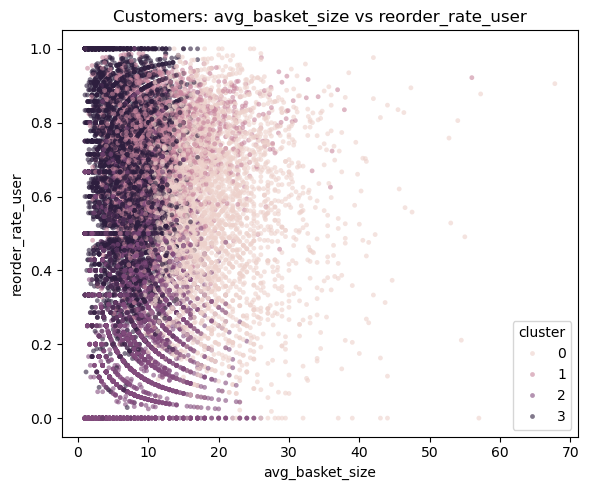

In [10]:
# Visualize Segments 

OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper: pick two columns that exist in a dataframe
def pick_axes(df, preferred_pairs):
    for x, y in preferred_pairs:
        if x in df.columns and y in df.columns:
            return x, y
    # fallback: any two numeric columns
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    num = [c for c in num if c != "cluster"]
    if len(num) >= 2:
        return num[0], num[1]
    raise ValueError("Not enough numeric columns to plot.")

# Scatter: basket size vs. reorder rate (or best available pair)

try:
    xcol, ycol = pick_axes(
        cust,
        preferred_pairs=[
            ("avg_basket_size", "reorder_rate_user"),
            ("n_orders", "reorder_rate_user"),
            ("n_orders", "avg_basket_size"),
        ],
    )
    n_samp = min(20000, len(cust))
    plot_df = cust[[xcol, ycol, "cluster"]].dropna().sample(n_samp, random_state=42) if len(cust) > 0 else cust

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=plot_df,
        x=xcol, y=ycol, hue="cluster",
        s=12, alpha=0.6, linewidth=0
    )
    plt.title(f"Customers: {xcol} vs {ycol}")
    plt.tight_layout()
    fname1 = OUT_DIR / f"seg_scatter_{xcol}_vs_{ycol}.png"
    plt.savefig(fname1, dpi=150)
    plt.show()
except Exception as e:
    print(f"[scatter skipped] {e}")

#### Scatter — Basket size vs. Reorder rate

**What it shows**  
Each point = a user (sampled for speed). X = `avg_basket_size`, Y = `reorder_rate_user`, color = `cluster`.

**How to read**
- Top-right = bigger baskets *and* high loyalty.
- Bottom-left = small baskets and low loyalty.
- Color separation suggests good cluster differentiation.

**This run (visual cues)**
- c1 (“Loyal power shoppers”) skews higher on Y.
- c0 (“Stock-up shoppers”) stretches right on X.

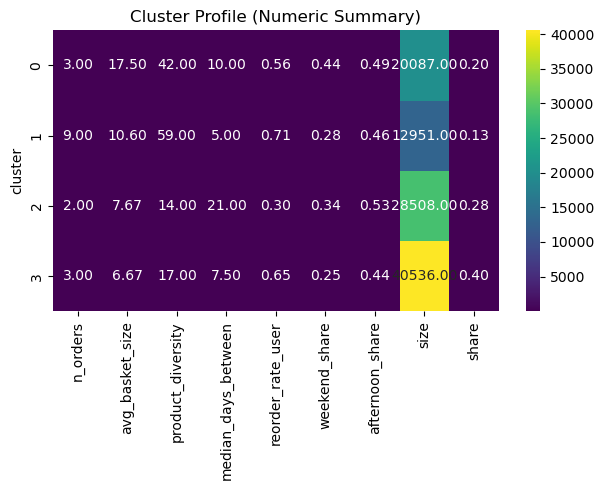

In [11]:
# Heatmap: cluster feature medians/means
try:
    # pick numeric columns for heatmap; drop non-numeric/meta columns
    hm = profiles.select_dtypes(include=[np.number]).copy()
    # optional: keep a compact set first if too wide
    if hm.shape[1] > 14:
        keep_first = [c for c in ["n_orders", "avg_basket_size", "reorder_rate_user",
                                  "product_diversity", "median_days_between",
                                  "weekend_share", "afternoon_share",
                                  "size", "share", "value_proxy", "loyalty_index"] if c in hm.columns]
        if keep_first:
            hm = hm[keep_first]

    plt.figure(figsize=(max(6, hm.shape[1]*0.7), 5))
    sns.heatmap(hm.round(2), annot=True, fmt=".2f", cmap="viridis")
    plt.title("Cluster Profile (Numeric Summary)")
    plt.tight_layout()
    fname2 = OUT_DIR / "seg_profile_heatmap.png"
    plt.savefig(fname2, dpi=150)
    plt.show()
except Exception as e:
    print(f"[heatmap skipped] {e}")

#### Heatmap — Cluster profile (numeric summary)

**What it shows**  
Per-cluster medians (or means for rate shares) across key features:
`n_orders`, `avg_basket_size`, `product_diversity`, `median_days_between`,
`reorder_rate_user`, `weekend_share`, `afternoon_share`, plus `size`/`share`.

**How to read**
- Darker cells = higher values for that cluster/feature.
- Compare rows to see what *defines* each cluster quickly.

**This run (high-level)**
- c1 leads on `reorder_rate_user`.
- c0 leads on `avg_basket_size`.
- c2 has longer `median_days_between`.

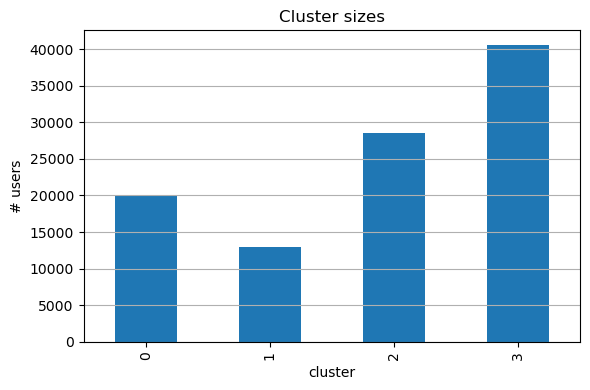

In [12]:
# Cluster sizes (bar)
try:
    if "size" in profiles.columns:
        plt.figure(figsize=(6, 4))
        profiles["size"].plot(kind="bar")
        plt.title("Cluster sizes")
        plt.ylabel("# users")
        plt.grid(axis="y")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"[sizes bar skipped] {e}")

#### Cluster sizes

**What it shows**  
Number of users per cluster (`profiles["size"]`).

**How to read**
- Sanity check balance (avoid one cluster ≫ 80%).
- Pairs with the heatmap’s `share` column for exact percentages.

**This run (approx.)**
- c3 ≈ largest, c1 ≈ smallest; c0/c2 in the middle.

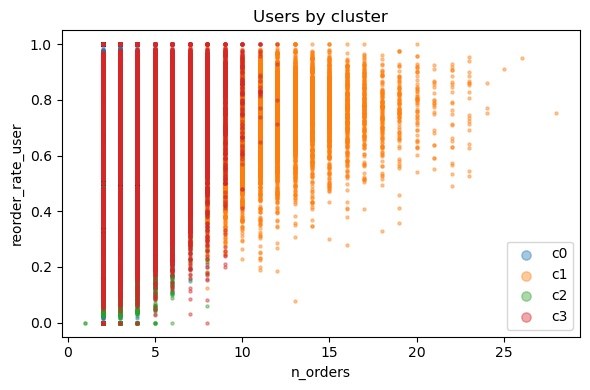

Saved figures to: /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/segmentation_instacart


In [13]:
# Two useful dimensions by cluster (fallback if needed)
try:
    x2, y2 = pick_axes(
        X_labeled,
        preferred_pairs=[
            ("n_orders", "reorder_rate_user"),
            ("n_orders", "avg_basket_size"),
        ],
    )
    plt.figure(figsize=(6, 4))
    for c in sorted(X_labeled["cluster"].dropna().unique()):
        pts = X_labeled[X_labeled["cluster"] == c]
        if x2 in pts.columns and y2 in pts.columns:
            plt.scatter(pts[x2], pts[y2], s=5, alpha=0.4, label=f"c{int(c)}")
    plt.xlabel(x2); plt.ylabel(y2)
    plt.title("Users by cluster")
    plt.legend(markerscale=3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[by-cluster scatter skipped] {e}")

print("Saved figures to:", OUT_DIR)


#### Users by cluster — `n_orders` vs `reorder_rate_user`

**What it shows**  
Another 2D view to validate separation: X = `n_orders`, Y = `reorder_rate_user`, color = `cluster`.

**How to read**
- Upward/rightward movement means more engaged and more loyal.
- Look for overlapping colors (possible candidates to merge/split in a different K).

**This run (visual cues)**
- c1 concentrates at higher `n_orders` and higher loyalty.

In [14]:
# Save artifacts

OUT_DIR.mkdir(parents=True, exist_ok=True)

# CSVs
seg.to_csv(OUT_DIR / "segments_user.csv", index=False)
profiles.round(4).to_csv(OUT_DIR / "segment_profiles.csv")

# Model summary (k + best silhouette)
sil_best = float(sils.get(best_k, np.nan)) if "sils" in globals() else np.nan
pd.DataFrame({"k": [int(best_k)], "silhouette": [sil_best]}).to_csv(
    OUT_DIR / "segment_model_summary.csv", index=False
)

# Persist transform + model for reuse
try:
    import joblib  # make sure this is in your imports block too

    to_save = {
        "imputer": imp_full,                                        # fitted SimpleImputer
        "scaler": scl_full if "scl_full" in globals() else None,    # fitted StandardScaler or None
        "kmeans": kmeans,                                           # fitted KMeans
        "feature_columns": X_df.columns.tolist(),                   # column order matters
        "id_col": ID_COL,
        "use_scaling": bool(globals().get("USE_SCALING", True)),
        "impute_strategy": globals().get("IMPUTE_STRATEGY", "median"),
        "best_k": int(best_k),
        "silhouette_by_k": {int(k): float(v) for k, v in sils.items()} if "sils" in globals() else {},
    }
    joblib.dump(to_save, OUT_DIR / "segment_model.joblib")
    print("Saved model artifacts.")
except Exception as e:
    print("Skip model dump:", e)

print(f"Saved artifacts in {OUT_DIR}/")


Saved model artifacts.
Saved artifacts in /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/segmentation_instacart/


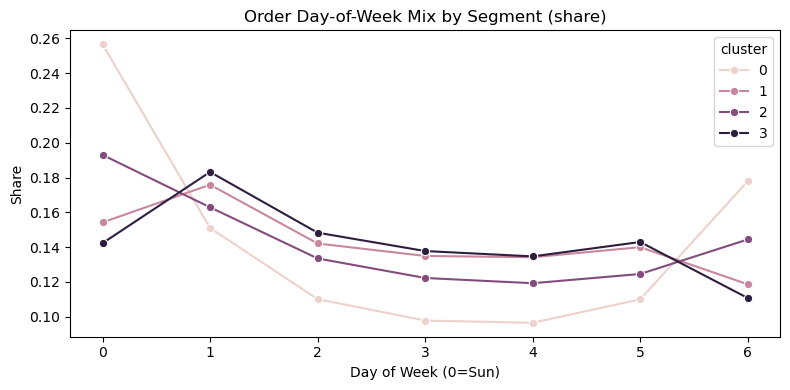

In [15]:
# Merge cluster labels back to orders (many orders per user -> many_to_one)
orders_w = orders.merge(
    cust[["cluster"]],            # cust index = user_id
    left_on=ID_COL,               # e.g., "user_id"
    right_index=True,
    how="left",
    validate="many_to_one"
).dropna(subset=["cluster"]).copy()

# ensure integer cluster labels
orders_w["cluster"] = orders_w["cluster"].astype("Int64")

OUT_DIR.mkdir(parents=True, exist_ok=True)

# Day-of-week share per cluster
if "order_dow" in orders_w.columns:
    g = (
        orders_w.groupby(["cluster", "order_dow"])
                .size()
                .reset_index(name="n")
                .sort_values(["cluster", "order_dow"])
    )
    g["share"] = g["n"] / g.groupby("cluster")["n"].transform("sum")
    dow = g.drop(columns="n")

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=dow, x="order_dow", y="share", hue="cluster", marker="o")
    plt.title("Order Day-of-Week Mix by Segment (share)")
    plt.xlabel("Day of Week (0=Sun)")
    plt.ylabel("Share")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "seg_dow_overlay.png", dpi=150)
    plt.show()
else:
    print("[skip] 'order_dow' not in orders; DOW chart omitted.")

#### Day-of-Week overlay (share by cluster)

**What it shows**  
Within each cluster, the **share** of orders across `order_dow` (0=Sun … 6=Sat).  
Shares are normalized **per cluster** (each cluster sums to 100%).

**How to read**
- Peaks indicate preferred shopping days by segment.
- Compare clusters for weekday vs weekend bias.

**This run (visual cues)**
- All segments show weekend lift; magnitude differs across clusters.

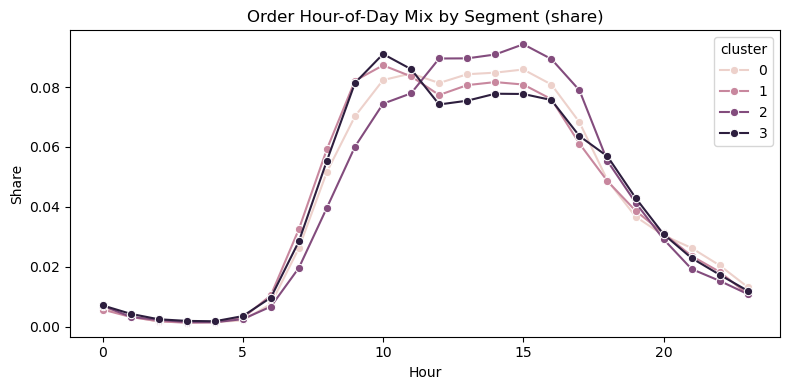

Saved figures to: /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/segmentation_instacart


In [16]:
# Hour-of-day share per cluster
if "order_hour_of_day" in orders_w.columns:
    g = (
        orders_w.groupby(["cluster", "order_hour_of_day"])
                .size()
                .reset_index(name="n")
                .sort_values(["cluster", "order_hour_of_day"])
    )
    g["share"] = g["n"] / g.groupby("cluster")["n"].transform("sum")
    hod = g.drop(columns="n")

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=hod, x="order_hour_of_day", y="share", hue="cluster", marker="o")
    plt.title("Order Hour-of-Day Mix by Segment (share)")
    plt.xlabel("Hour")
    plt.ylabel("Share")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "seg_hod_overlay.png", dpi=150)
    plt.show()
else:
    print("[skip] 'order_hour_of_day' not in orders; HOD chart omitted.")

print("Saved figures to:", OUT_DIR)

#### Hour-of-Day overlay (share by cluster)

**What it shows**  
Within each cluster, the **share** of orders across `order_hour_of_day` (0–23).
Shares are normalized **per cluster**.

**How to read**
- Midday/evening peaks are common; segment shifts suggest timing for nudges.
- Use to schedule notifications and promos by segment.

**This run (visual cues)**
- Afternoon peak across segments; slight differences in evening taper.

### Notes & caveats
- Scatter plots sample up to 20k users for speed; exact counts in the CSVs.
- Heatmap includes only numeric features present in `profiles`.
- Overlays are normalized **within** each cluster; compare shapes, not levels.
- Plots reflect the current `best_k`; if you re-run with a new K, re-export figures.

In [17]:
# Save labeled customers for downstream work (A/B targeting, uplift, etc.)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Use all columns except 'cluster' as features
feature_cols = [c for c in cust.columns if c != "cluster"]

out = cust[feature_cols + ["cluster"]].copy()
out.index.name = ID_COL  # make the index name explicit in the CSV

out_path = OUT_DIR / "customer_segments.csv"
summary_path = OUT_DIR / "segment_profile_summary.csv"

out.to_csv(out_path, index=True)              # index = user_id
summary.round(4).to_csv(summary_path)

print("Saved:")
print(" -", out_path)
print(" -", summary_path)

Saved:
 - /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/segmentation_instacart/customer_segments.csv
 - /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/segmentation_instacart/segment_profile_summary.csv


### Findings & Actions 


#### Findings
**Chosen K:** `<best_k>` (via silhouette).  
**Segments (size share):**  
- c0 — `<auto_label_0>` — `<pct_0>%`  
- c1 — `<auto_label_1>` — `<pct_1>%`  
- c2 — `<auto_label_2>` — `<pct_2>%`  
- …  

**What differs most:** `<brief note on n_orders / avg_basket_size / cadence / loyalty>`

*Tables used: `segment_profile_summary.csv` (size/share + summary stats)*


#### Segment cheat sheet (fill from profile table)

- **c0 — `<auto_label_0>`**  
  - `n_orders` (median): `<val>`  
  - `avg_basket_size` (median): `<val>`  
  - `median_days_between` (median): `<val>`  
  - `reorder_rate_user` (mean, if available): `<val>`  
  - `product_diversity` (median, if available): `<val>`

- **c1 — `<auto_label_1>`**  
  - …

- **c2 — `<auto_label_2>`**  
  - …

#### Recommended actions (testable, 02-style)

- **Loyal power shoppers** (high `n_orders` & high `reorder_rate_user`)  
  - **Action:** early access, bundles, loyalty tiers  
  - **KPI:** items/order or AOV ↑; **Guardrail:** margin, return rate

- **Light / early lifecycle** (low `n_orders`)  
  - **Action:** onboarding nudges, 2nd-order coupons, starter kits  
  - **KPI:** 30-day repeat ↑; **Guardrail:** CAC per retained user

- **Infrequent planners** (high `median_days_between`)  
  - **Action:** calendar reminders, auto-reorder suggestions  
  - **KPI:** days-between ↓; **Guardrail:** unsubscribe rate

- **Stock-up shoppers** (high `avg_basket_size`)  
  - **Action:** bulk/volume discounts, pantry restock bundles  
  - **KPI:** gross margin/order ↑; **Guardrail:** OOS/substitution rate

- **Explorers** (high `product_diversity`)  
  - **Action:** discovery emails, “new this week”, aisle spotlights  
  - **KPI:** category breadth ↑; **Guardrail:** cart abandonment

*Always validate with an A/B or holdout test before scaling.*

#### Ops & BI handoff
- Load: `segments_user.csv`, `segment_profile_summary.csv`, `feature_matrix.csv`  
- Charts to reproduce in 04/BI: cluster sizes, DOW/HOD overlays, basket/cadence by cluster

#### Quality checks
- No cluster >80% of users; profiles differ meaningfully.  
- `k_choice.json` recorded; reruns with `SAMPLE_FRAC < 1.0` tell the same story.

#### Next steps
- Try nearby K values; sanity-check stability.  
- If spend exists in another dataset, add RFM monetary.  
- Add time-evolution: segment transitions month-over-month.